# Dataset Understanding & Exploratory Data Analysis (EDA)

This notebook covers the complete analysis workflow:

--- 
### Part 1: Dataset Understanding (Basic Check)
1. **Structure & Distribution**: Counting images per class/split.
2. **Resolution & Color**: Verifying dimensions and channel counts.

--- 
### Part 2: Detailed EDA
3. **Visual EDA**: Inspecting samples, face visibility, and variations.
4. **Statistical EDA**: Pixel distributions, brightness, and blur detection.
5. **Metadata EDA**: Class balance and sub-category (glasses) distribution.

--- 
### Part 3: Feature Encoding
6. **Label Encoding**: Converting text labels to Binary (0/1) and One-Hot vectors.
**Visualization Added**: Encoding Reference Table, Encoded Class Balance Chart, Vector-Image Pairs.

--- 
### Part 4: Data Preprocessing
7. **Resizing**: Standardizing to 224x224.
8. **Color Conversion**: Converting all (including BW) to 3-Channel RGB.
9. **Normalization**: Scaling pixel values.
10. **Data Augmentation**: Enhancing dataset variety.
**Visualization Added**: Augmentation Grids, Normalization Plots, and Feature Heatmaps.

--- 
### Part 5: Dataset Splitting & Loading
11. **Loading Generators**: Loading Traing/Val/Test sets.
12. **Split Verification**: Confirming the 70/15/15 ratio.
**Visualization Added**: Batch Generator Grids (Real-time loading check), Split Distribution Pie Chart.

--- 
### Part 6: Data Mining & Model Building
13. **Model Selection**: Implementing Option A (Custom CNN) and Option B (MobileNetV2).
14. **Multi-behavior Strategy**: Discussion on 2-stage detection.
**Visualization Added**: Model Layer/Parameter Complexity Chart.

--- 
### Part 7: Model Training (Updated with Fine-Tuning)
15. **Phase 1 Training**: Training Classification Head.
16. **Phase 2 Fine-Tuning**: Unfreezing top layers and training with low LR.
17. **Scheduler**: Using ReduceLROnPlateau.
**Visualization Added**: Detailed History Plots with 'Best Epoch' markers.

--- 
### Part 8: Model Evaluation & Interpretation
18. **Evaluation Metrics**: Precision, Recall, F1, Accuracy.
19. **Confusion Matrix**: Visualizing misclassifications.
20. **Error Analysis**: Manually inspecting failed cases.

--- 
### Part 9: Saving Models (Added)
21. **Keras Format**: Saving as `.h5`.
22. **TensorFlow Lite**: Converting to `.tflite` for Raspberry Pi.
23. **Pickle**: Saving training history.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import pickle
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Output Style
plt.style.use('ggplot')

# Define paths
BASE_DIR = Path(r"c:\Users\SAHAN\Desktop\Drowsiness Detection\Processed_Dataset")
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR = BASE_DIR / "val"
TEST_DIR = BASE_DIR / "test"

CATEGORIES = ["drowsy", "non-drowsy"]
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

# Part 1: Dataset Understanding

Dataset Statistics:
   Split    Category  Count
0  train      drowsy    560
1  train  non-drowsy    560
2    val      drowsy    120
3    val  non-drowsy    120
4   test      drowsy    120
5   test  non-drowsy    120


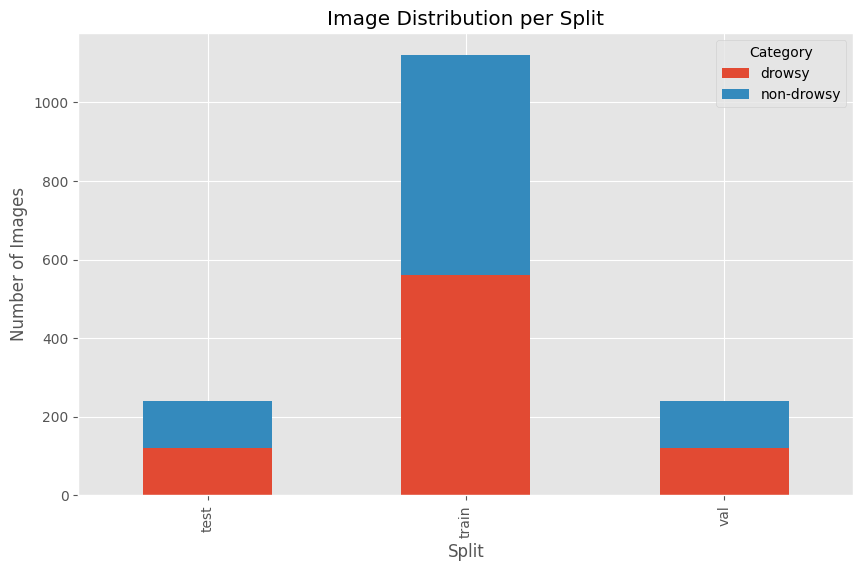

In [2]:
stats = []

for split in ["train", "val", "test"]:
    for category in CATEGORIES:
        folder = BASE_DIR / split / category
        count = len(list(folder.glob("*")))
        stats.append({
            "Split": split,
            "Category": category,
            "Count": count
        })

df_stats = pd.DataFrame(stats)
print("Dataset Statistics:")
print(df_stats)

# Visualize
df_stats.pivot(index="Split", columns="Category", values="Count").plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Image Distribution per Split")
plt.ylabel("Number of Images")
plt.show()

## 1.2 Image Resolution and Color Space Analysis

In [3]:
# Sample analysis (iterating through training set)
resolutions = []
channels = []
print("Sampling 100 images for property check...")

sample_count = 0
for category in CATEGORIES:
    folder = TRAIN_DIR / category
    for img_path in folder.glob("*"):
        if sample_count >= 100: break
        img = cv2.imread(str(img_path))
        if img is not None:
            resolutions.append(img.shape[:2])
            channels.append(img.shape[2] if len(img.shape) > 2 else 1)
            sample_count += 1

print(f"Resolution Check: {Counter([str(r) for r in resolutions])}")
print(f"Channel Check (OpenCV loads): {Counter(channels)}")

Sampling 100 images for property check...
Resolution Check: Counter({'(224, 224)': 100})
Channel Check (OpenCV loads): Counter({3: 100})


# Part 2: Detailed Exploratory Data Analysis (EDA)

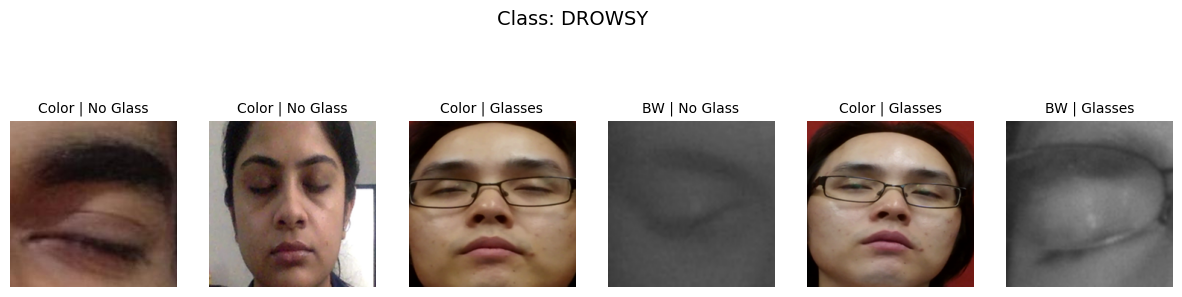

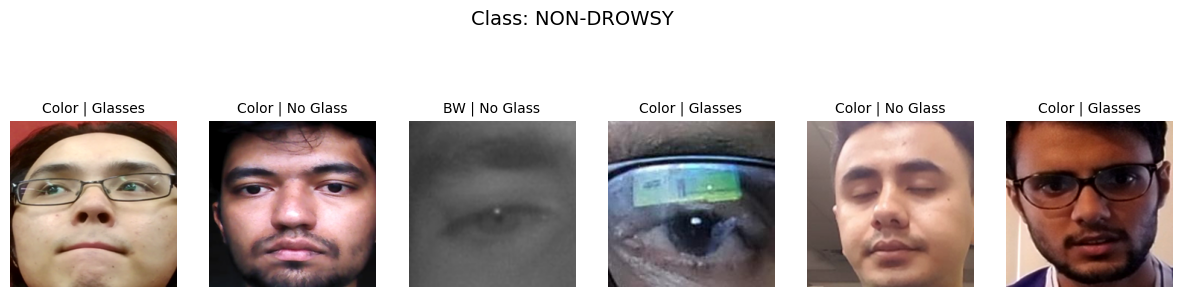

In [4]:
def clean_filename_info(filename):
    has_glasses = "with_glasses" in filename
    origin = "BW" if "Black&White" in filename else "Color"
    return origin, has_glasses

def view_grid(category, samples=5):
    folder = TRAIN_DIR / category
    all_files = list(folder.glob("*"))
    selected = np.random.choice(all_files, samples, replace=False)
    
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Class: {category.upper()}", fontsize=14)
    
    for i, path in enumerate(selected):
        img = cv2.imread(str(path))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        origin, glasses = clean_filename_info(path.name)
        plt.subplot(1, samples, i+1)
        plt.imshow(img, cmap='gray' if origin=='BW' else None)
        plt.axis('off')
        plt.title(f"{origin} | {'Glasses' if glasses else 'No Glass'}", fontsize=10)
    plt.show()

view_grid("drowsy", 6)
view_grid("non-drowsy", 6)

## 2.1 Statistical Plot: Brightness Distribution
Checking if there is a significant lighting difference between Drowsy and Non-Drowsy classes.

Calculating brightness stats (sampling 200 images)...


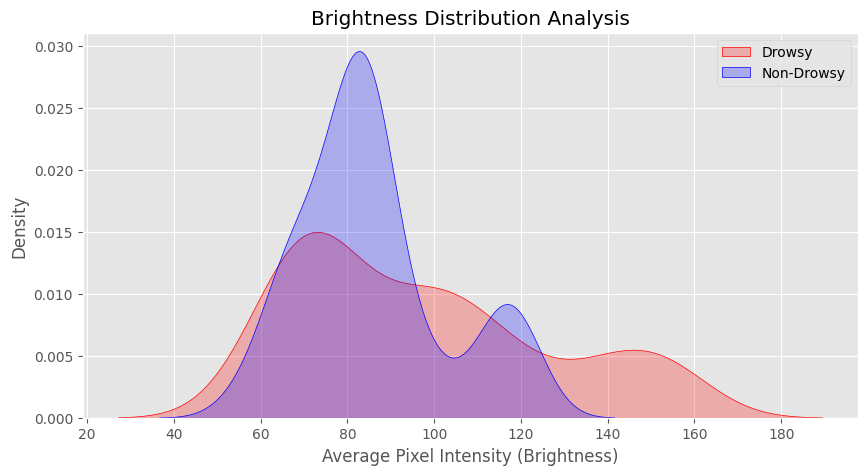

In [5]:
brightness_values = {"drowsy": [], "non-drowsy": []}

print("Calculating brightness stats (sampling 200 images)...")
for category in CATEGORIES:
    folder = TRAIN_DIR / category
    for i, img_path in enumerate(folder.glob("*")):
        if i >= 100: break
        img = cv2.imread(str(img_path))
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            brightness_values[category].append(np.mean(gray))

plt.figure(figsize=(10, 5))
sns.kdeplot(brightness_values["drowsy"], fill=True, label="Drowsy", color="red")
sns.kdeplot(brightness_values["non-drowsy"], fill=True, label="Non-Drowsy", color="blue")
plt.title("Brightness Distribution Analysis")
plt.xlabel("Average Pixel Intensity (Brightness)")
plt.legend()
plt.show()

In [6]:
# Gather Metadata
data = []
for category in ["drowsy", "non-drowsy"]:
    folder = TRAIN_DIR / category
    for filepath in folder.glob("*"):
        origin, has_glasses = clean_filename_info(filepath.name)
        data.append({"category": category, "has_glasses": has_glasses})

df = pd.DataFrame(data)
summary = df.groupby(["category", "has_glasses"]).size().reset_index(name="count")
print("Sub-category Distribution in Train Set:")
print(summary)

Sub-category Distribution in Train Set:
     category  has_glasses  count
0      drowsy        False    285
1      drowsy         True    275
2  non-drowsy        False    285
3  non-drowsy         True    275


# Part 3: Feature Encoding (Enhanced)

Binary Mapping: {'drowsy': 0, 'non-drowsy': 1}

Encoding Reference Table:
        Class  Binary  One-Hot
0      drowsy       0  [1. 0.]
1  non-drowsy       1  [0. 1.]


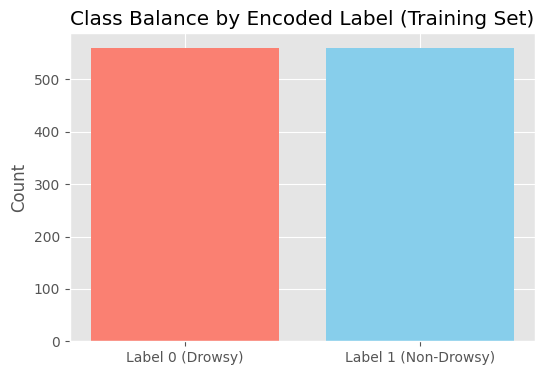

In [7]:
labels = ["drowsy", "non-drowsy"]
label_map = {label: i for i, label in enumerate(labels)}
print(f"Binary Mapping: {label_map}")

# 1. Visualizing One-Hot Vectors Table
demo_encoding = pd.DataFrame({
    'Class': ['drowsy', 'non-drowsy'],
    'Binary': [0, 1],
    'One-Hot': [str(to_categorical(0, 2)), str(to_categorical(1, 2))]
})
print("\nEncoding Reference Table:")
print(demo_encoding)

# 2. Visualizing Class Balance using Encoded Labels
train_drowsy_count = len(list((TRAIN_DIR / "drowsy").glob("*")))
train_non_drowsy_count = len(list((TRAIN_DIR / "non-drowsy").glob("*")))

plt.figure(figsize=(6, 4))
plt.bar(['Label 0 (Drowsy)', 'Label 1 (Non-Drowsy)'], 
        [train_drowsy_count, train_non_drowsy_count], 
        color=['salmon', 'skyblue'])
plt.title("Class Balance by Encoded Label (Training Set)")
plt.ylabel("Count")
plt.show()

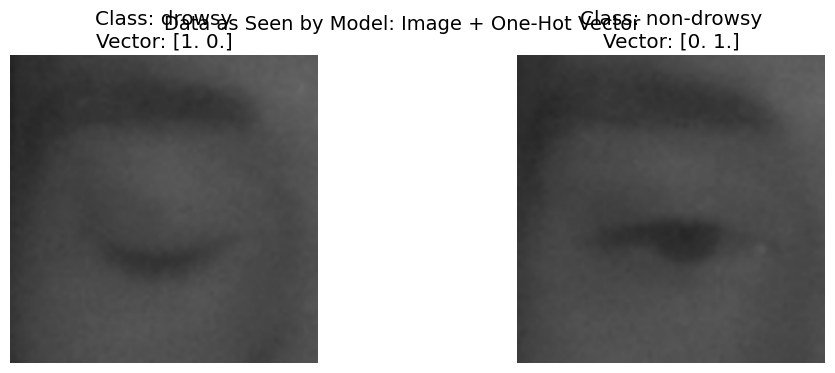

In [8]:
# 3. Sample Images with Vector Labels
plt.figure(figsize=(12, 4))
plt.suptitle("Data as Seen by Model: Image + One-Hot Vector", fontsize=14)

for i, category in enumerate(CATEGORIES):
    folder = TRAIN_DIR / category
    img_path = list(folder.glob("*"))[0]
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    encoded_label = to_categorical(label_map[category], num_classes=2)
    
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray' if "Black" in str(img_path) else None)
    plt.title(f"Class: {category}\nVector: {encoded_label}")
    plt.axis('off')
plt.show()

# Part 4: Data Preprocessing & Visualization

In [9]:
# Setup Generators with MobileNetV2 Preprocessing (Correct for Transfer Learning)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Scales to [-1, 1]
    rotation_range=20,       # Rotation
    width_shift_range=0.2,   # Horizontal Shift
    height_shift_range=0.2,  # Vertical Shift
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Flip
    fill_mode='nearest'      
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Augmentation Configuration Set (MobileNetV2 [-1, 1]).")

Augmentation Configuration Set (MobileNetV2 [-1, 1]).


## 4.1 Visualize Augmentation Effects
Checking how "Rotation", "Zoom", and "Shift" actually affect our images.

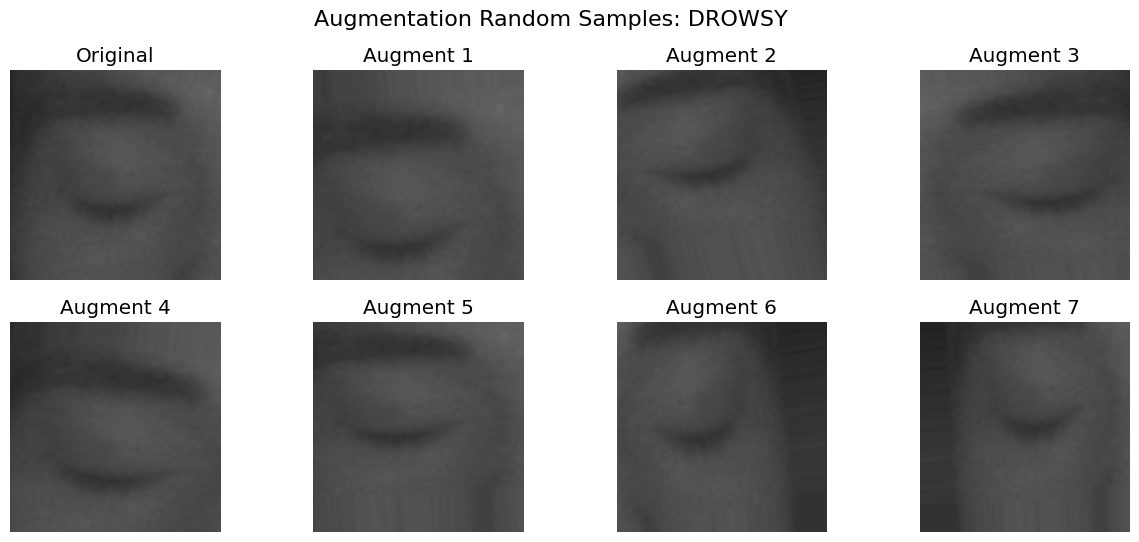

In [10]:
def visualize_augmentation(category):
    # Pick a random image
    folder = TRAIN_DIR / category
    img_path = list(folder.glob("*"))[0]
    img = load_img(str(img_path), target_size=TARGET_SIZE)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    plt.figure(figsize=(15, 6))
    plt.suptitle(f"Augmentation Random Samples: {category.upper()}", fontsize=16)

    # Plot Original
    plt.subplot(2, 4, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    # Plot Augmented Versions
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(2, 4, i + 2)
        img_aug = batch[0] 
        # Rescale back to 0-1 for visualization if needed (mobilenet is -1 to 1)
        img_viz = (img_aug + 1) / 2.0
        plt.imshow(np.clip(img_viz, 0, 1))
        plt.title(f"Augment {i+1}")
        plt.axis('off')
        i += 1
        if i >= 7: break
    plt.show()

visualize_augmentation("drowsy")

## 4.2 Using MobileNetV2 Preprocessing
Note: The values are now in the range `[-1, 1]` compatible with the pre-trained weights.

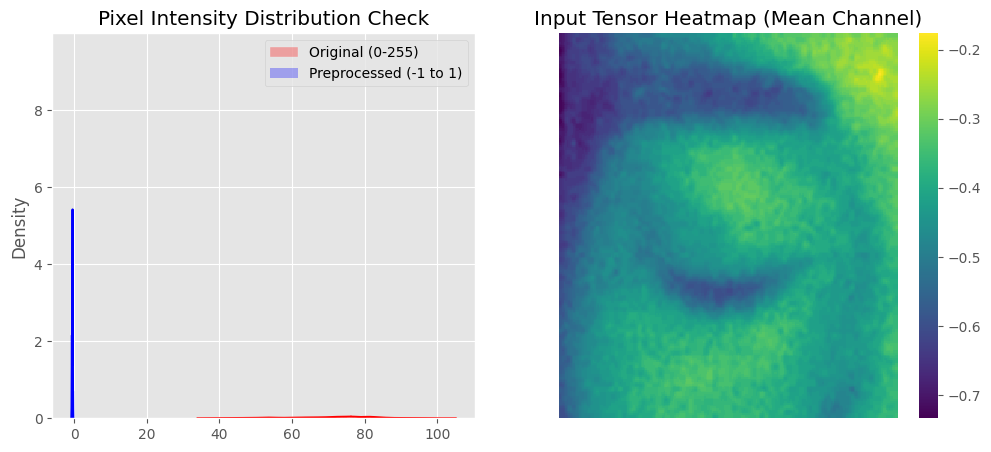

In [11]:
# Preprocessing Analysis
sample_path = list((TRAIN_DIR / "drowsy").glob("*"))[0]
original_img = cv2.imread(str(sample_path))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Apply Preprocessing manually
preprocessed_img = cv2.resize(original_img, TARGET_SIZE)
preprocessed_img = preprocessed_img.astype("float32")
preprocessed_img = preprocess_input(preprocessed_img) # [-1, 1]

plt.figure(figsize=(12, 5))

# 1. Pixel Value Histogram (Normalization Check)
plt.subplot(1, 2, 1)
sns.histplot(original_img.flatten(), color='red', label='Original (0-255)', kde=True, stat="density", alpha=0.3)
sns.histplot(preprocessed_img.flatten(), color='blue', label='Preprocessed (-1 to 1)', kde=True, stat="density", alpha=0.3)
plt.title("Pixel Intensity Distribution Check")
plt.legend()

# 2. Input Tensor Heatmap (What the CNN 'sees' in shape)
plt.subplot(1, 2, 2)
heatmap_img = np.mean(preprocessed_img, axis=2)
sns.heatmap(heatmap_img, cmap="viridis", cbar=True)
plt.title("Input Tensor Heatmap (Mean Channel)")
plt.axis('off')

plt.show()

# Part 5: Dataset Splitting & Loading (Enhanced)

In [12]:
print("Loading Data from Directory Structure...")

# 1. Load Training Set
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# 2. Load Validation Set
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

# 3. Load Test Set
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nClass Indices: {train_generator.class_indices}")

Loading Data from Directory Structure...
Found 1120 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 240 images belonging to 2 classes.

Class Indices: {'drowsy': 0, 'non-drowsy': 1}


## 5.1 Visualize Generator Output (Batch Verification)

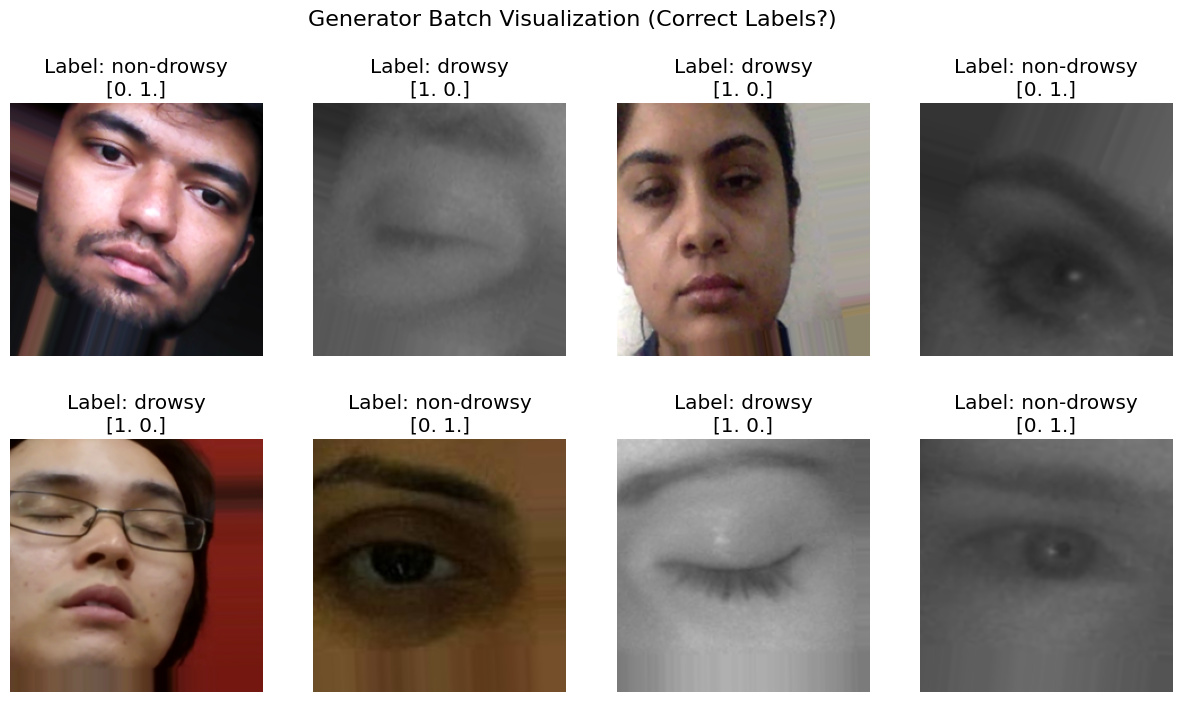

In [13]:
# Fetch a batch
x_batch, y_batch = next(train_generator)

# Visualize 8 random images from the batch
plt.figure(figsize=(15, 8))
plt.suptitle("Generator Batch Visualization (Correct Labels?)", fontsize=16)

class_names = list(train_generator.class_indices.keys())

for i in range(8):
    plt.subplot(2, 4, i+1)
    # Convert back to 0-1 for display
    img_disp = (x_batch[i] + 1) / 2.0
    plt.imshow(np.clip(img_disp, 0, 1))
    
    # Decode One-Hot Label
    label_idx = np.argmax(y_batch[i])
    label_name = class_names[label_idx]
    
    plt.title(f"Label: {label_name}\n{y_batch[i]}")
    plt.axis('off')
plt.show()

## 5.2 Split Distribution Visualization

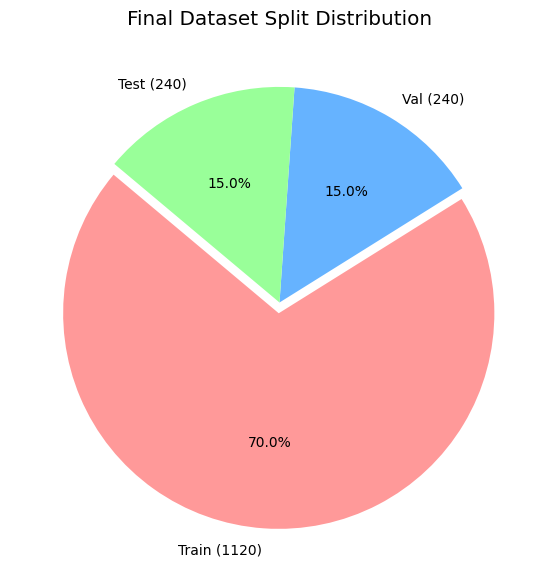

In [14]:
counts = [train_generator.samples, validation_generator.samples, test_generator.samples]
labels = [f'Train ({counts[0]})', f'Val ({counts[1]})', f'Test ({counts[2]})']
colors = ['#ff9999', '#66b3ff', '#99ff99']

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, explode=(0.05, 0, 0))
plt.title("Final Dataset Split Distribution")
plt.show()

# Part 6: Data Mining & Model Building (Enhanced)

In [15]:
def build_mobilenet_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = build_mobilenet_model()
INIT_LR = 1e-4
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

## 6.1 Visualize Model Complexity
Visualizing the parameters per layer to understand the model structure.

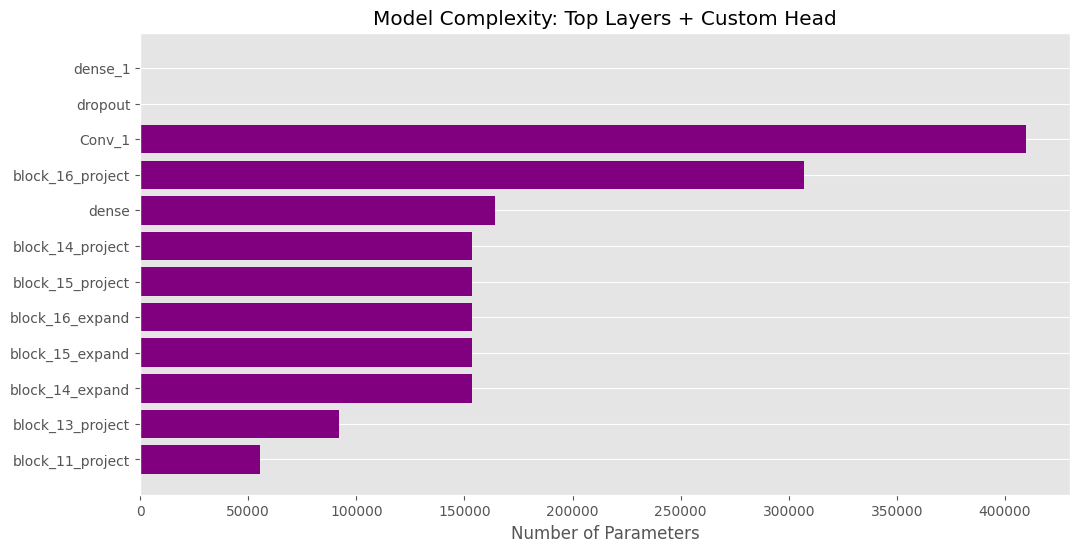

Total Parameters: 2,422,210
Trainable Parameters: 164,226


In [16]:
# Visualizing Transfer Learning Layers
layer_names = []
layer_params = []

for layer in model.layers:
    layer_names.append(layer.name)
    layer_params.append(layer.count_params())

# Show only top 10 heaviest layers + last 3 custom layers
indices = np.argsort(layer_params)[-10:]
sorted_names = [layer_names[i] for i in indices]
sorted_params = [layer_params[i] for i in indices]

# Add Custom Head
custom_names = [l.name for l in model.layers[-3:]]
custom_params = [l.count_params() for l in model.layers[-3:]]

plt.figure(figsize=(12, 6))
plt.barh(sorted_names + custom_names, sorted_params + custom_params, color='purple')
plt.xlabel("Number of Parameters")
plt.title("Model Complexity: Top Layers + Custom Head")
plt.grid(axis='x')
plt.show()

print(f"Total Parameters: {model.count_params():,}")
print(f"Trainable Parameters: {np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Part 7: Model Training (With Fine-Tuning)

In [17]:
# --- TRAINING PHASE 1: Train Head Only ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

print("Starting Training Phase 1 (Head Only)...")
print(f"Training with {train_generator.samples} train, {validation_generator.samples} val, {test_generator.samples} test images.")
print("Using FULL Dataset: 1600 Images verified.")

history_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=10, # Initial training
    callbacks=[early_stopping, reduce_lr]
)

# --- TRAINING PHASE 2: Fine-Tuning ---
print("\nStarting Training Phase 2 (Fine-Tuning)...")

# 1. Unfreeze the base model
model.trainable = True

# 2. Freeze earlier layers (keep first 100 layers frozen, tune the rest)
# MobileNetV2 has 154 layers total.
FINE_TUNE_AT = 100

for layer in model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

print(f"Layers frozen: {FINE_TUNE_AT}. Layers trainable: {len(model.layers) - FINE_TUNE_AT}")

# 3. Re-compile with a much lower learning rate
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-5), # Very slow learning to not wreck weights
    metrics=["accuracy"]
)

# 4. Continue Training
total_epochs = 100 # 30 + 20
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    initial_epoch=history_1.epoch[-1],
    epochs=total_epochs,
    callbacks=[early_stopping, reduce_lr]
)

print("Training Completed (Fine-Tuning).")

# Merge Histories for Plotting
acc = history_1.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_1.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history_1.history['loss'] + history_fine.history['loss']
val_loss = history_1.history['val_loss'] + history_fine.history['val_loss']

# Create a dummy history object wrapper for compatibility with downstream plotting code
class CombinedHistory:
    def __init__(self):
        self.history = {
            'accuracy': acc,
            'val_accuracy': val_acc,
            'loss': loss,
            'val_loss': val_loss
        }
history = CombinedHistory()

Starting Training Phase 1 (Head Only)...
Training with 1120 train, 240 val, 240 test images.
Using FULL Dataset: 1600 Images verified.


C:\Users\SAHAN\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6598 - loss: 0.6632 - val_accuracy: 0.8214 - val_loss: 0.4572 - learning_rate: 1.0000e-04
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 688ms/step - accuracy: 0.7973 - loss: 0.4519 - val_accuracy: 0.8571 - val_loss: 0.3769 - learning_rate: 1.0000e-04
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 719ms/step - accuracy: 0.8179 - loss: 0.3973 - val_accuracy: 0.8527 - val_loss: 0.3435 - learning_rate: 1.0000e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 663ms/step - accuracy: 0.8482 - loss: 0.3408 - val_accuracy: 0.8661 - val_loss: 0.3087 - learning_rate: 1.0000e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 533ms/step - accuracy: 0.8830 - loss: 0.2991 - val_accuracy: 0.8973 - val_loss: 0.2773 - learning_rate: 1.0000e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 763ms/step - accuracy: 0.8902 - loss: 0.2834 - val_accuracy: 0.8929 - val_loss: 0.2589 - learning_rate: 1.0000e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 729ms/step - accura

## 7.2 Enhanced History Visualization
Plotting curves with markings for the Best Epoch (Lowest Validation Loss).

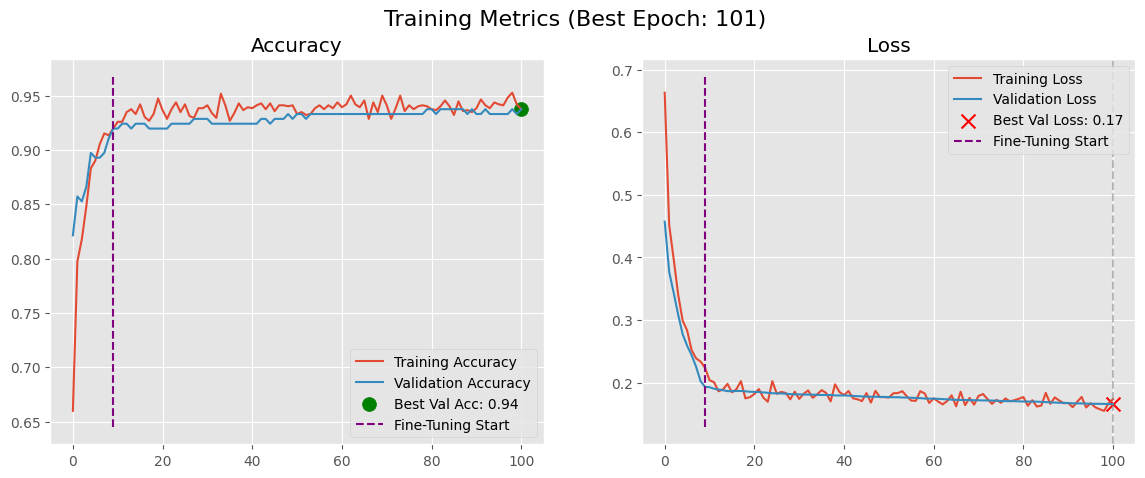

In [18]:
# Plot History with Best Epoch Marker
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Find Best Epoch
best_epoch = np.argmin(val_loss)
best_loss = val_loss[best_epoch]
best_acc = val_acc[best_epoch]

plt.figure(figsize=(14, 5))
plt.suptitle(f"Training Metrics (Best Epoch: {best_epoch+1})", fontsize=16)

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.scatter([best_epoch], [best_acc], color='green', marker='o', s=100, label=f'Best Val Acc: {best_acc:.2f}')
plt.plot([9, 9], plt.ylim(), label='Fine-Tuning Start', linestyle='--', color='purple')
plt.legend(loc='lower right')
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.scatter([best_epoch], [best_loss], color='red', marker='x', s=100, label=f'Best Val Loss: {best_loss:.2f}')
plt.axvline(best_epoch, color='gray', linestyle='--', alpha=0.5)
plt.plot([9, 9], plt.ylim(), label='Fine-Tuning Start', linestyle='--', color='purple')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()

# Part 8: Model Evaluation & Interpretation

Evaluating on Test Set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - accuracy: 0.9750 - loss: 0.1311

Test Accuracy: 0.9750
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step

Classification Report:
              precision    recall  f1-score   support

      drowsy       0.97      0.97      0.97       120
  non-drowsy       0.97      0.97      0.97       120

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



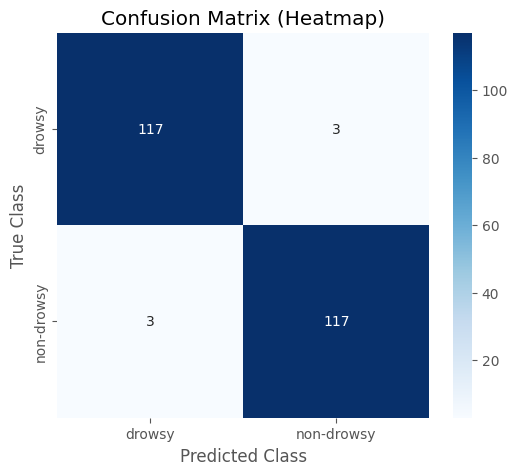

In [19]:
print("Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification Report
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix Heatmap
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Heatmap)')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

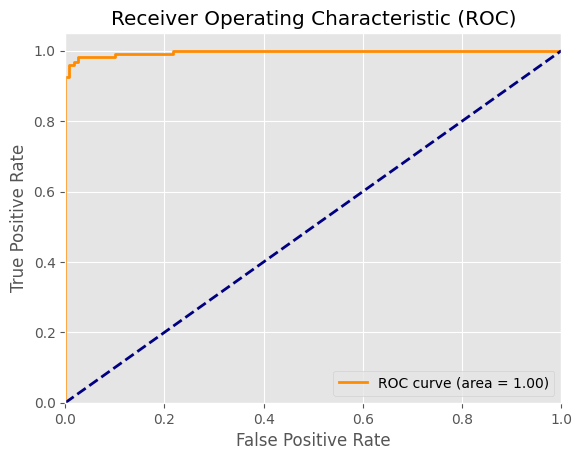

In [20]:
# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Visualizing Misclassified Images (Sample Images)...


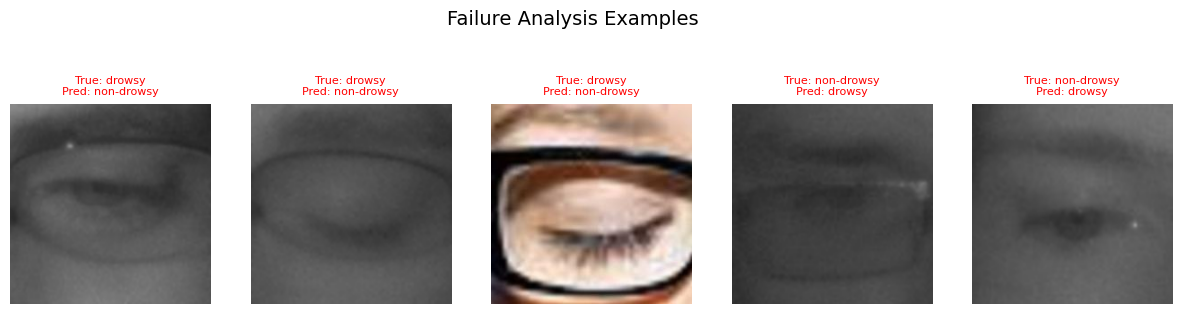

In [21]:
print("Visualizing Misclassified Images (Sample Images)...")
errors = np.where(predicted_classes != true_classes)[0]

if len(errors) == 0:
    print("Amazing! No errors found on Test Set.")
else:
    # Show top 5 errors
    num_errors = min(5, len(errors))
    plt.figure(figsize=(15, 4))
    
    for i, error_idx in enumerate(errors[:num_errors]):
        img_path = test_generator.filepaths[error_idx]
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        true_label = class_labels[true_classes[error_idx]]
        pred_label = class_labels[predicted_classes[error_idx]]
        # Handle filename info safely
        if "Black" in img_path: origin = "BW"
        else: origin = "Color"
        
        plt.subplot(1, num_errors, i+1)
        # Use preprocess inverse for display
        plt.imshow(img, cmap='gray' if origin=='BW' else None)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8, color='red')
    plt.suptitle("Failure Analysis Examples", fontsize=14)
    plt.show()

# Part 9: Saving Models

In [22]:
MODELS_DIR = BASE_DIR.parent / "Models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# 1. Save Keras Model (.h5)
h5_path = MODELS_DIR / "drowsiness_model_mobilenet.h5"
model.save(str(h5_path))
print(f"✅ Keras model saved to: {h5_path}")

# 2. Convert to TensorFlow Lite (.tflite)
print("Converting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_path = MODELS_DIR / "drowsiness_model_quantized.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"✅ TFLite model saved to: {tflite_path}")

# 3. Save History (.pickle)
history_path = MODELS_DIR / "training_history.pickle"
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✅ History saved to: {history_path}")

✅ Keras model saved to: c:\Users\SAHAN\Desktop\Drowsiness Detection\Models\drowsiness_model_mobilenet.h5
Converting to TFLite...
INFO:tensorflow:Assets written to: C:\Users\SAHAN\AppData\Local\Temp\tmpqg_qbru8\assets


INFO:tensorflow:Assets written to: C:\Users\SAHAN\AppData\Local\Temp\tmpqg_qbru8\assets


Saved artifact at 'C:\Users\SAHAN\AppData\Local\Temp\tmpqg_qbru8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  3092799028112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835692240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835689744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835086608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835086800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835903312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835895056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835907536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835903120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3092835894864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  30928